In [1]:
import gcsfs
import cftime
import intake
from cmip6_preprocessing.preprocessing import combined_preprocessing
from xgcm import Grid
import numpy as np
import xesmf as xe
import xarray as xr

from matplotlib import pyplot as plt
import cartopy as cy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo

### Download CMIP6 data and regrid with CFSR data

Download CMIP6 data

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6-noQC.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(table_id='Omon', 
                 experiment_id=['historical'],
                 variable_id=['thetao'],
                 member_id=['r1i1p1f1'],
                 grid_label='gn',
                 source_id=['MPI-ESM1-2-HR']
                )

cmip6_compiled = cat.to_dataset_dict(
            zarr_kwargs={'consolidated':True, 'decode_times': True, 'use_cftime': True},
            preprocess=combined_preprocessing
            )


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/Users/odyssey/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/Users/odyssey/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self

Download reanalysis dataset

In [3]:
URL = 'https://ds.nccs.nasa.gov/thredds/dodsC/bypass/CREATE-IP/reanalysis/CFSR/mon/ocean/thetao.ncml'
CFSR_thetao = xr.open_dataset(URL,engine='netcdf4')

lat = CFSR_thetao.lat
lon = CFSR_thetao.lon

obs_grid = xr.Dataset(
    {
        "lat": (["lat"], lat),
        "lon": (["lon"], lon),
    }
)

obs_lev = CFSR_thetao.lev

Regrid CMIP6 to CFSR horizontal grid

In [4]:
ds = cmip6_compiled['CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn']
regridder = xe.Regridder(ds,obs_grid, 'nearest_s2d')
ds_regridded = regridder(ds)

/Users/odyssey/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/xesmf/frontend.py:499: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


Create grid object from CMIP6 data

In [5]:
cmip6_thetao = ds_regridded.thetao

grid = Grid(cmip6_thetao, coords={'Z': {'center': 'lev', 'outer': 'lev_bounds'},
                        'X': {'center': 'lon'},
                        'Y': {'center': 'lat'}},
            periodic=False
            )

Use xgcm transform to interpolate CMIP6 temperature data to CFSR vertical grid

In [6]:
cmip6_interp_thetao = grid.transform(cmip6_thetao, 'Z', obs_lev, target_data=None, method='linear')

Plot CMIP6 temperature at specific depth

Text(0.5, 1.0, 'CMIP6 temperature at 15 m')

<Figure size 432x288 with 0 Axes>

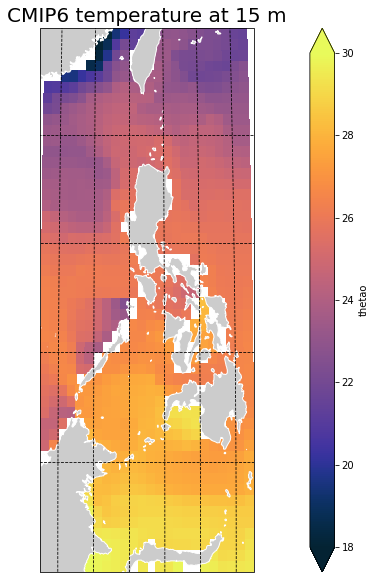

In [7]:
plt.figure()
fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = plt.axes(projection=ccrs.Mollweide(120))
ax.set_extent([115,127,0,25])
ax.gridlines(linestyle='--',color='black')

cmip6_interp_thetao.sel(lon=slice(115,127),lat=slice(0,25), 
                       lev=15, time='1979-01-16').squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                                                            vmin=18, vmax=30,
                                                                            cmap=cmo.thermal)

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='w', facecolor='0.8')

ax.add_feature(coast_10m)
ax.set_title('CMIP6 temperature at 15 m', fontsize=20)

Plot CFSR at same depth

Text(0.5, 1.0, 'CFSR temperature at 15 m')

<Figure size 432x288 with 0 Axes>

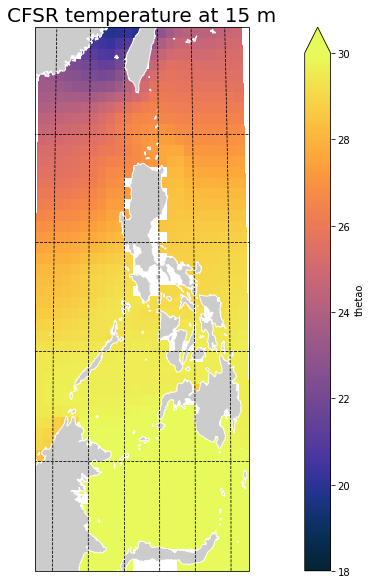

In [8]:
plt.figure()
fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = plt.axes(projection=ccrs.Mollweide(120))
ax.set_extent([115,127,0,25])
ax.gridlines(linestyle='--',color='black')

plotCFSR = CFSR_thetao.thetao.sel(lon=slice(115,127),lat=slice(0,25), 
                       lev=15, time='1979-01-16').squeeze()

plotCFSR = plotCFSR-271

plotCFSR.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),vmin=18, vmax=30, cmap=cmo.thermal)

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='w', facecolor='0.8')

ax.add_feature(coast_10m)
ax.set_title('CFSR temperature at 15 m', fontsize=20)

### Try regrid with WOA data

In [9]:
URL = 'https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa/temperature/decav81B0/0.25/woa18_decav81B0_t00_04.nc'
WOA_temp = xr.open_dataset(URL,engine='netcdf4',
                          decode_times=False) 

In [10]:
lat = WOA_temp.lat
lon = WOA_temp.lon

obs_grid = xr.Dataset(
    {
        "lat": (["lat"], lat),
        "lon": (["lon"], lon),
    }
)

obs_lev = WOA_temp.depth

In [11]:
ds = cmip6_compiled['CMIP.MPI-M.MPI-ESM1-2-HR.historical.Omon.gn']
regridder = xe.Regridder(ds,obs_grid, 'nearest_s2d')
ds_regridded = regridder(ds)

/Users/odyssey/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/xesmf/frontend.py:499: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


In [12]:
cmip6_thetao = ds_regridded.thetao

grid = Grid(cmip6_thetao, coords={'Z': {'center': 'lev', 'outer': 'lev_bounds'},
                        'X': {'center': 'lon'},
                        'Y': {'center': 'lat'}},
            periodic=False
            )

In [13]:
cmip6_interp_thetao = grid.transform(cmip6_thetao, 'Z', obs_lev, target_data=None, method='linear')

/Users/odyssey/miniconda3/envs/xesmf_env/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'CMIP6 temperature at 15 m')

<Figure size 432x288 with 0 Axes>

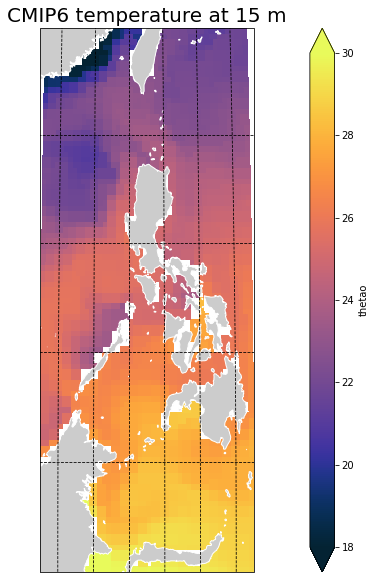

In [14]:
plt.figure()
fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = plt.axes(projection=ccrs.Mollweide(120))
ax.set_extent([115,127,0,25])
ax.gridlines(linestyle='--',color='black')

cmip6_interp_thetao.sel(lon=slice(115,127),lat=slice(0,25), 
                       depth=15, time='1981-01-16').mean(dim='time').squeeze().plot.pcolormesh(ax=ax, 
                                                                            transform=ccrs.PlateCarree(),
                                                                            vmin=18, vmax=30,
                                                                            cmap=cmo.thermal)

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='w', facecolor='0.8')

ax.add_feature(coast_10m)
ax.set_title('CMIP6 temperature at 15 m', fontsize=20)

Text(0.5, 1.0, 'WOA temperature at 15 m')

<Figure size 432x288 with 0 Axes>

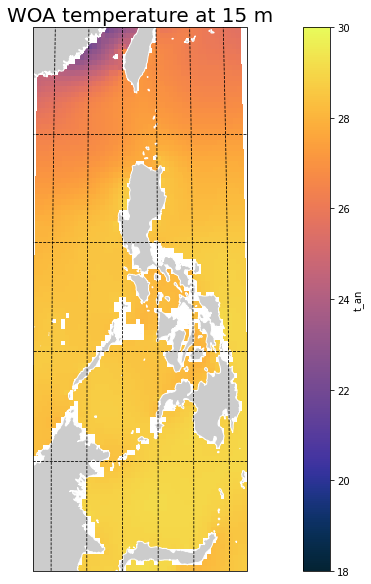

In [15]:
plt.figure()
fig = plt.figure(figsize=(20, 10), facecolor='white')
ax = plt.axes(projection=ccrs.Mollweide(120))
ax.set_extent([115,127,0,25])
ax.gridlines(linestyle='--',color='black')

WOA_temp.t_an.sel(lon=slice(115,127),lat=slice(0,25), 
                       depth=15).mean(dim='time').squeeze().plot.pcolormesh(ax=ax, 
                                                                            transform=ccrs.PlateCarree(),
                                                                            vmin=18, vmax=30,
                                                                            cmap=cmo.thermal)

coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='w', facecolor='0.8')

ax.add_feature(coast_10m)
ax.set_title('WOA temperature at 15 m', fontsize=20)

### Run example from docs

In [ ]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["GODAS"].to_dask()